In [1]:
from lava.proc.lif.process import LIF
from lava.proc.dense.process import Dense
from lava.proc.spiker.process import Spiker
from lava.proc.monitor.process import Monitor
from lava.proc.io.source import RingBuffer
from lava.magma.core.run_conditions import RunSteps, RunContinuous
from lava.magma.core.run_configs import Loihi1SimCfg

import numpy as np

num_steps = 20

In [2]:
def get_input_buffer(data):
    buffer_data = np.concatenate((np.array(data), np.zeros(num_steps - len(data))))
    
    return RingBuffer(data=np.array([buffer_data]))


# create a neuron with a specified name and spiking threshold
# These neurons send a spike for only one time step and remember their voltage
def create_neuron(name, threshold=0.999999, dv=0):
    neuron = LIF(shape=(1, ),                         # Number and topological layout of units in the process
           vth=threshold,                              # Membrane threshold
           dv=dv,                              # Inverse membrane time-constant
           du=1,                              # Inverse synaptic time-constant
           bias_mant=0.0,              # Bias added to the membrane voltage in every timestep
           name=name)
    
    return neuron


# create multiple neurons
def create_neurons(name, nr, threshold=0.999999, dv=0):
    neurons = []
    for i in range(nr):
        neuron = create_neuron(name + str(i), threshold=threshold, dv=dv)
        neurons.append(neuron)
        
    return neurons
        

# connect neuron1 to neuron2 with a specified weight and delay
# minimal delay is 1
def connect_neurons(neuron1, neuron2, weight=1.0, delay=1):
    input_neuron = neuron1
    
    conn = Dense(weights=np.array([[weight]]), name='conn')
    neuron1.s_out.connect(conn.s_in)
    
    for i in range(delay - 1):
        conn_delay = Dense(weights=np.array([[weight]]), name='conn_delay')
        conn.a_out.connect(conn_delay.s_in)
        conn = conn_delay
        
    conn.a_out.connect(neuron2.a_in)

In [3]:
def run_and_plot(neurons, run_neuron):
    monitors = []
    for neuron in neurons:
        monitor = Monitor()
        monitor.probe(neuron.u, num_steps)
        monitors.append(monitor)

    # run conditions
    run_condition = RunSteps(num_steps=num_steps)
    run_cfg = Loihi1SimCfg(select_tag="floating_pt")

    # run network and get results
    run_neuron.run(condition=run_condition, run_cfg=run_cfg)

    for monitor in monitors:
        monitor.get_data()

    # plot results
    import matplotlib
    %matplotlib inline
    from matplotlib import pyplot as plt

    total = len(neurons)
    cols = 3
    rows = total // cols
    
    if total % cols != 0:
        rows += 1
    
    position = range(1, total + 1)
    
    fig = plt.figure(1, figsize=(16,10))
    for i in range(total):
        # Create a subplot for each monitor
        ax = fig.add_subplot(rows, cols, position[i])

        # Plot the recorded data
        monitors[i].plot(ax, neurons[i].u)

## Crossover Ensemble

In [4]:
class CrossoverEnsemble():
    def __init__(self, neurons_a_in, neurons_b_in, leading):
        self.neurons_a_in = neurons_a_in
        self.neurons_b_in = neurons_b_in
        self.leading = leading
        
        self.m = len(neurons_a_in) - 2
        
        # create crossover_point, should be a value that let 0 to n-2 neurons spike resulting in possible crossover
        self.random_list = np.random.random(num_steps)
        self.pivot = get_input_buffer(self.random_list)
        
        # create output neurons
        self.neurons_a_out = create_neurons('out_a', len(neurons_a_in))
        self.neurons_b_out = create_neurons('out_b', len(neurons_a_in))
        
        # identity first bit
        connect_neurons(self.neurons_a_in[0], self.neurons_a_out[0], delay=2)
        connect_neurons(self.neurons_b_in[0], self.neurons_b_out[0], delay=2)
        
        # crossover middle based on pivot
        self.random_point_maker('a')
        self.random_point_maker('b')

        # crossover last bit
        connect_neurons(self.neurons_a_in[-1], self.neurons_b_out[-1], delay=2)
        connect_neurons(self.neurons_b_in[-1], self.neurons_a_out[-1], delay=2)
    

    def random_point_maker(self, name):
        if name == 'a':
            neurons_in = self.neurons_a_in
            neurons_out_id = self.neurons_a_out
            neurons_out_cross = self.neurons_b_out
        else:
            neurons_in = self.neurons_b_in
            neurons_out_id = self.neurons_b_out
            neurons_out_cross = self.neurons_a_out

        for i in range(1, self.m + 1):
            threshold = 1 - (1 / (self.m + 1)) * i
            
            # gate: activated for pivot > threshold (and leading bit active)
            gate_i = create_neuron('gate_'+name+str(i), threshold=1 + threshold, dv=1)
            self.pivot.s_out.connect(gate_i.a_in)
            self.leading.s_out.connect(gate_i.a_in)

            # output links from gate 
            id_i = create_neuron('id_'+name+str(i), dv=1)
            cross_i = create_neuron('cross_'+name+str(i), threshold=1.999999, dv=1)
            
            # connect input and gate to identity neuron
            connect_neurons(neurons_in[i], id_i)
            connect_neurons(gate_i, id_i, weight=-1)
            
            # connect input and gate to crossover neuron
            connect_neurons(neurons_in[i], cross_i)
            connect_neurons(gate_i, cross_i)

            # connect identity and crossover neuron to correct outputs
            connect_neurons(id_i, neurons_out_id[i])
            connect_neurons(cross_i, neurons_out_cross[i])
        
        
    def get_output_neurons(self):
        new_leading = create_neuron('leading')
        connect_neurons(self.leading, new_leading, delay=2)
        return new_leading, self.neurons_a_out, self.neurons_b_out

### Test crossover ensemble

In [5]:
lead_buffer = get_input_buffer([1, 0])
leading = create_neuron('leading')
lead_buffer.s_out.connect(leading.a_in)

def create_crossover_inputs():
    buffers_a = [get_input_buffer([1, 0]), get_input_buffer([0, 0]), get_input_buffer([1, 0]), get_input_buffer([0, 0])]
    buffers_b = [get_input_buffer([1, 0]), get_input_buffer([1, 0]), get_input_buffer([0, 0]), get_input_buffer([1, 0])]
    
    neurons_a_in = []
    neurons_b_in = []
    for i in range(len(buffers_a)):
        neurons_a_in.append(create_neuron('in_a' + str(i)))
        buffers_a[i].s_out.connect(neurons_a_in[i].a_in)
        
        neurons_b_in.append(create_neuron('in_b' + str(i)))
        buffers_b[i].s_out.connect(neurons_b_in[i].a_in)
        
    return neurons_a_in, neurons_b_in

neurons_a_in, neurons_b_in = create_crossover_inputs()
crossover = CrossoverEnsemble(neurons_a_in, neurons_b_in, leading)
l, a, b = crossover.get_output_neurons()

# test first/last bits of sequence:
#run_and_plot([a[0]], neurons_a_in[0])
#run_and_plot([b[3]], neurons_a_in[3])

# test middle bits of sequence:
print(neurons_a_in)
# run_and_plot([a[1], b[1], a[2], b[2]], leading)

[<lava.proc.lif.process.LIF object at 0x000002985F7823A0>, <lava.proc.lif.process.LIF object at 0x000002985F782D60>, <lava.proc.lif.process.LIF object at 0x000002985F789760>, <lava.proc.lif.process.LIF object at 0x000002985F790160>]


## Mutation Ensemble
Mutate each of the bits with a fixed probability

In [6]:
# mutating a neuron costs 2 time-steps?
def mutate_neuron(neuron_in, leading, prob):
    random_a = get_input_buffer(np.random.choice([0, 1], size=(num_steps,), p=[1-prob, prob]))

    # mutate neuron deciding whether input should be mutated (iff random=1 & leading=1)
    mutate_a = create_neuron('mutate_a', threshold=1.999, dv=1)
    random_a.s_out.connect(mutate_a.a_in)
    leading.s_out.connect(mutate_a.a_in)

    #input_a = get_input_buffer([1, 0, 0])

    check_a1 = create_neuron('check_a1', threshold=0.999, dv=1)
    check_a2 = create_neuron('check_a2', threshold=0.999, dv=1)

    connect_neurons(mutate_a, check_a1)
    connect_neurons(mutate_a, check_a2, weight=-1)

    connect_neurons(neuron_in, check_a1, weight=-1)
    connect_neurons(neuron_in, check_a2)

    neuron_out = create_neuron('neuron_out', threshold=0.999)
    connect_neurons(check_a1, neuron_out)
    connect_neurons(check_a2, neuron_out)
    
    return neuron_out

In [7]:
# input: 
# - leading bit (telling at what time step the genome passes)
# - list of input neurons (to mutate)
# - mutation probability (for each neuron)

# output:
# - leading bit (input leading bit with delay of 2)
# - list of output neurons (mutated)
def mutation_ensemble(leading, input_neurons, prob=0.5):
    output_neurons = []
    for neuron in input_neurons:
        neuron_out = mutate_neuron(neuron, leading, prob)
        output_neurons.append(neuron_out)
        
    # add delay to leading neuron same as mutation delay
    new_leading = create_neuron('leading')
    connect_neurons(leading, new_leading, delay=2)
    
    return new_leading, output_neurons

### Testing the mutation ensemble

In [8]:
lead_buffer = get_input_buffer([1, 0])
in_l = create_neuron('in_l')
connect_neurons(lead_buffer, in_l)

buffer_a = get_input_buffer([1])
buffer_b = get_input_buffer([0])
buffer_c = get_input_buffer([1])
in_a = create_neuron('in_a')#get_input_buffer([1, 0, 0, 0])
in_b = create_neuron('in_b')# get_input_buffer([1, 0, 0, 0])
in_c = create_neuron('in_c')# get_input_buffer([1, 0, 0, 0])
connect_neurons(buffer_a, in_a)
connect_neurons(buffer_b, in_b)
connect_neurons(buffer_c, in_c)

input_neurons = [in_a, in_b, in_c]

# create buffers that feed into input neurons
leading, output_neurons = mutation_ensemble(in_l, input_neurons, 1)

# connect output of mutation_ensemble to input leading bit
leading.s_out.connect(in_l.a_in)

for i in range(3):
    output_neurons[i].s_out.connect(input_neurons[i].a_in)

# run_and_plot(output_neurons, output_neurons[0])

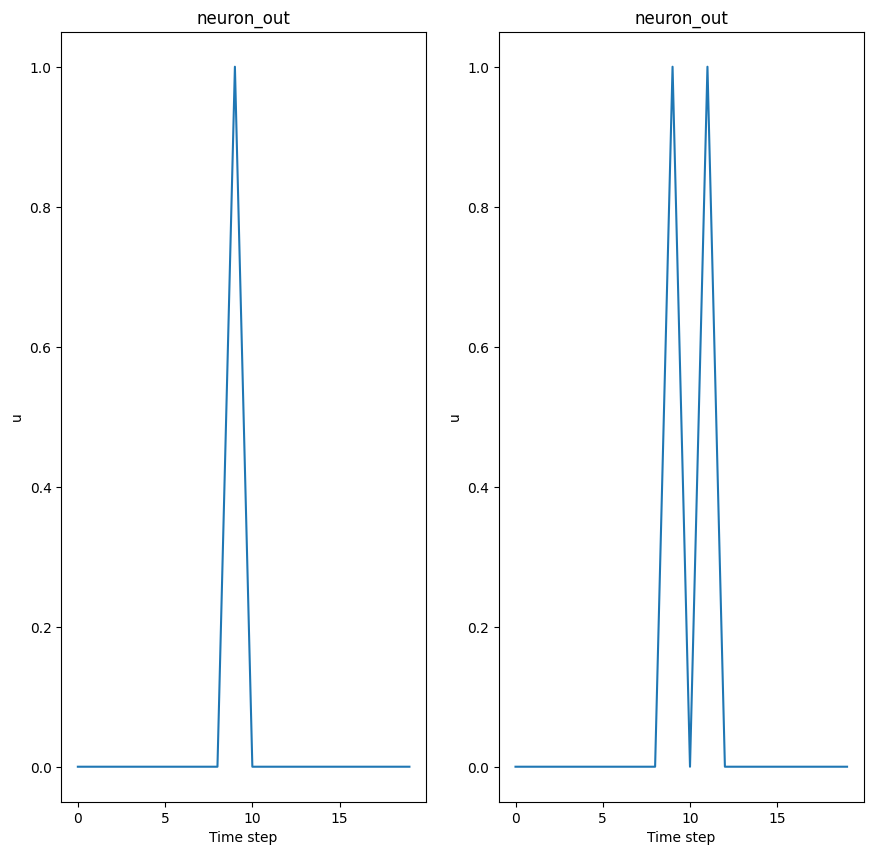

In [9]:
class Evolution():
    def __init__(self, chromosomes, num_gens=1):
        self.input_buffers = [[get_input_buffer([gene,0]) for gene in chromosome] for chromosome in chromosomes]
        self.leading = [get_input_buffer([1,0]) for _ in range(int(len(chromosomes)/2))]
        self.num_gens = num_gens
        self.input_neurons = []
        self.evaluated_neurons = [None, None]
        self.crossover_neurons = [None, None]
        self.mutated_neurons = [None,None]

        self.leading_neurons = []
        self.output_neurons_a = None
        self.output_neurons_b = None

    def create_input_neurons(self):
        neurons_a_in = []
        neurons_b_in = []
        for i in range(len(self.input_buffers[0])):
            neurons_a_in.append(create_neuron('in_a' + str(i)))
            connect_neurons(self.input_buffers[0][i], neurons_a_in[i])
            
            neurons_b_in.append(create_neuron('in_b' + str(i)))
            connect_neurons(self.input_buffers[1][i], neurons_b_in[i])
        self.input_neurons = [neurons_a_in, neurons_b_in]

    def create_leading_neurons(self):
        leading_in = []
        for i in range(len(self.leading)):
            self.leading_neurons.append(create_neuron('l_' + str(i)))
            connect_neurons(self.leading[i], self.leading_neurons[i])

    def create_output_neurons(self):
        pass

    def evaluation(self):
        self.input_neurons = self.input_neurons[0]+self.input_neurons[1]
        input_size = len(self.input_neurons)


        #first layer to ACC
        acc = create_neuron('acc', threshold=0.999)
        for i in range(int(input_size/2)):
            connect_neurons(self.input_neurons[i], acc, weight=-1, delay=1)
            connect_neurons(self.input_neurons[i+int(input_size/2)], acc, weight=1, delay=1)

        #Create second layer 
        second_layer_Gi = []
        second_layer_Gs = []
        for i in range(input_size):
            second_layer_Gi.append(create_neuron("Gi " + str(i), threshold=0.999))
            second_layer_Gs.append(create_neuron("Gs " + str(i), threshold=1.998))

        # Connect ACC and first layer to second layer
        for i in range(input_size):
            connect_neurons(acc, second_layer_Gi[i], weight=-1, delay=1)
            connect_neurons(acc, second_layer_Gs[i], weight=1, delay=1)
            connect_neurons(self.input_neurons[i], second_layer_Gi[i], weight=1, delay=2)
            connect_neurons(self.input_neurons[i], second_layer_Gs[i], weight=1, delay=2)

        # Connect second layer to output
        output = []
        for i in range(input_size):
            output.append(create_neuron("O " + str(i), threshold=0.999))
            connect_neurons(second_layer_Gi[i], output[i], weight=1, delay=1)

        for i in range(int(input_size/2)):
            connect_neurons(second_layer_Gs[i], output[i+int(input_size/2)], weight=1, delay=2)
            connect_neurons(second_layer_Gs[i+int(input_size/2)], output[i], weight=1, delay=2)

        new_leading = create_neuron('leading')
        connect_neurons(self.leading_neurons[0], new_leading, delay=4)
        self.leading_neurons[0] = new_leading
        
        self.evaluated_neurons[0], self.evaluated_neurons[1] = output[0:3], output[3:7]



    def crossover(self):
        crossover = CrossoverEnsemble(self.evaluated_neurons[0], self.evaluated_neurons[1], self.leading_neurons[0])
        self.leading_neurons[0], self.crossover_neurons[0], self.crossover_neurons[1] = crossover.get_output_neurons()

    def mutation(self):
        for n in range(len(self.crossover_neurons)):
            self.leading_neurons[0], self.mutated_neurons[n] = mutation_ensemble(self.leading_neurons[0], self.crossover_neurons[n], prob=1)

    def evolution_process(self):
        self.create_leading_neurons()
        self.create_input_neurons()
        self.evaluation()
        self.crossover()
        self.mutation()
        run_and_plot([self.mutated_neurons[0][1], self.mutated_neurons[1][1]], self.input_neurons[1])



E = Evolution([[1,0,1],[1,1,1]])
E.evolution_process()

In [10]:
input_buffer = get_input_buffer([1,0])
input_neuron = [create_neuron('n1')]
connect_neurons(input_buffer, input_neuron[0])
second_neuron = [create_neuron('n2')]
connect_neurons(input_neuron[0], second_neuron[0], delay=5)

# run_and_plot([input_neuron[0], second_neuron[0]], input_neuron[0])